This project is greatly inspired by the following article:

[Building a full-text search engine in 150 lines of Python code](https://bart.degoe.de/building-a-full-text-search-engine-150-lines-of-code/)

and the Information Retrieval and Web Search lectures at the University of Mannheim, Germany

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip install datasets
# ! pip install nltk
# ! pip install tqdm

In [3]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from search import bool_retrieval, phrase_retrieval, vsm, bim, bim_extension, query_likelihood, tf, idf, unigram_model, searching
from saveload import save_load
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

[nltk_data] Downloading package words to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 6.5 s, sys: 4.31 s, total: 10.8 s
Wall time: 3.69 s


# Indexing the documents collection

In [4]:
%%time
# inverted_index_sortpost,inverted_index_unsortpost,positional_index_sortpost,positional_index_unsortpost,term_freqs_log,\
# term_freqs_raw, doc_freqs, unigram=save_load(dataset="ms_marco", save=True, save_path="./data")
inverted_index_sortpost=save_load(dataset="ms_marco", save=True, save_path="./data")

.....................Inverted Index with sorted postings.....................


Reusing dataset ms_marco (/home/georges_sarr/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
100%|██████████| 9650/9650 [00:35<00:00, 272.82it/s]


CPU times: user 37.2 s, sys: 1.04 s, total: 38.2 s
Wall time: 39.3 s


# Statistics

In [5]:
print(f"The vocabulary is made of {len(inverted_index_sortpost.index)} words")

The vocabulary is made of 135109 words


### Document lengths

There are 79176 documents


<AxesSubplot:ylabel='Count'>

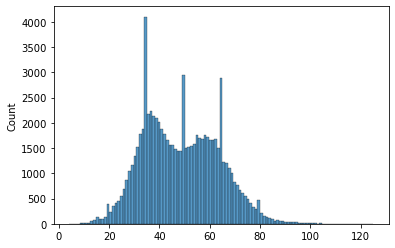

In [6]:
print(f"There are {len(inverted_index_sortpost.documents)} documents")
doc_lenghts=[len(inverted_index_sortpost.raw_freq[ID]) for ID in inverted_index_sortpost.documents]
sb.histplot(doc_lenghts)

In [7]:
round(pd.DataFrame({"doc_lengths": doc_lenghts}).describe(),0)

,doc_lengths
count,79176.0
mean,49.0
std,15.0
min,4.0
25%,37.0
50%,48.0
75%,60.0
max,125.0


### Word raw frequencies

In [8]:
# average number of time each token appears in a document
avg_raw_freqs = [np.mean([inverted_index_sortpost.raw_freq[ID][term] for ID in inverted_index_sortpost.index[term]]) for term in inverted_index_sortpost.index]
round(pd.DataFrame({"avg_raw_freqs":avg_raw_freqs}).describe(),0)

,avg_raw_freqs
count,135109.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,24.0


Most of the terms appear just once in a document.

### Document frequencies

In [9]:
%%time 
doc_freqs=[len(inverted_index_sortpost.index[token]) for token in inverted_index_sortpost.index]
round(pd.DataFrame({"doc_freqs": doc_freqs}).describe(),0)

CPU times: user 93.5 ms, sys: 138 µs, total: 93.7 ms
Wall time: 93 ms


,doc_freqs
count,135109.0
mean,28.0
std,565.0
min,1.0
25%,1.0
50%,2.0
75%,4.0
max,73633.0


A term appears on average in 28 $\pm$ 565 documents, 75% of the terms appear in less than 4 documents (a lot of rare terms, weird ??). Lets try to visualize why

In [10]:
for pos , term in enumerate(inverted_index_sortpost.index) : 
    if pos<=500 and len(inverted_index_sortpost.index[term])<=4: print(term) 

stink
npr
deters
contributory
fuels-oil
nonrenewable
coal-take
circumscribes
4cm
polygons-properties
incircle
congruent
mathworld
weisstein
--a
sagitta
inradius
hypotenuse


It looks plausible when we look at the above sequence of words (they are rare indeed)

In [11]:
# tfreqs, idfs, unigram=tf(inverted_index_sortpost), idf(inverted_index_sortpost), unigram_model(inverted_index_sortpost)
tfreqs, idfs =tf(inverted_index_sortpost), idf(inverted_index_sortpost)

# Searching

## Simple boolean retrieval

In [13]:
searching(index=inverted_index_sortpost, modl='bool', retrieve_max=3)

Document(ID=202, content='The most common causes behind an inflamed pancreas are prolonged alcohol abuse and gallstones. Some hereditary disorders can cause pancreatitis, as can certain medications and viruses. When pancreatitis is caused by medication and viruses, it is usually an acute attack and rarely long-lived.') 

Document(ID=418, content='Plutonium is a member of the actinide group in the periodic table. Plutonium atoms have 94 electrons and 94 protons with 2 valence electrons in the outer shell. There are 150 neutrons in the most abundant isotope. Plutonium is used in both nuclear reactors and nuclear weapons. It was used to create the second nuclear weapon deployed during World War II which was the Fat Man nuclear bomb dropped on Nagasaki, Japan. Plutonium has also been used as a power and heat source for spacecraft.') 

Document(ID=459, content='Fox News figures are using a possible al Qaeda plot to falsely claim that President Obama declared the war on terror over. The Stat

## Phrase queries retrieval PENDING( POSITIONAL INDEXING TAKES TIME TO RUN DUE TO PREPROCESSING)

In [ ]:
# %%time
# query='''the effects of humidity on the mach number and static pressure in the
# working section were investigated and the results are compared with
# theoretical estimates at a nominal mach number 2.0'''
# phrase_retrieval(positional_index_sortpost, query)

## Vector Space Model

In [14]:
searching(inverted_index_sortpost, tfreqs, idfs, modl='tf_idf', retrieve_max=3)

(Document(ID=68411, content='Heat is also known as Energy. Heat can be transferred between objects by radiation, conduction and convection. Temperature is used as a measure of the internal energy or enthalpy, that is the level of elementary motion giving rise to heat transfer. Heat can only be transferred between objects, or areas within an object, with different temperatures (as given by the zeroth law of thermodynamics).'), 'score = 7.821683854082291') 

(Document(ID=68417, content='Therefore, to change the energy of a system, energy must be transferred to or from the system. Heat and work are the only two mechanisms by which energy can be transferred to or from a control mass. Heat is the transfer of energy caused by the temperature difference. Temperature is used as a measure of the internal energy or enthalpy, that is the level of elementary motion giving rise to heat transfer. Heat can only be transferred between objects, or areas within an object, with different temperatures (as

## Binary Independence models

In [16]:
searching(inverted_index_sortpost, tfreqs, idfs, modl='bim', retrieve_max=3)

(Document(ID=19, content="Apothem of a Regular Polygon. Definition: A line segment from the center of a regular polygon to the midpoint of a side. Try this Adjust the polygon below by dragging any orange dot, or alter the number of sides. Note the behavior of the apothem line shown in blue. The word apothem can refer to the line itself, or the length of that line. So you can correctly say 'draw the apothem' and 'the apothem is 4cm'. Each formula below shows how to find the length of the apothem of a regular polygon. Use the formula that uses the facts you are given to start."), 'score = 4.120442306873306') 

(Document(ID=21, content="The apothem is also the radius of the incircle of the polygon. For a polygon of n sides, there are n possible apothems, all the same length of course. The word apothem can refer to the line itself, or the length of that line. So you can correctly say 'draw the apothem' and 'the apothem is 4cm'. Each formula below shows how to find the length of the apothem

In [ ]:
%%time
bim_extension(query, positional_index_sortpost, term_freqs_log, extension='two_poisson', top=3)

## Language model

In [22]:
%%time
query_likelihood(query, inverted_index_sortpost, unigram, top=3)

CPU times: user 2.28 ms, sys: 870 µs, total: 3.15 ms
Wall time: 3.05 ms


[(Document(ID=5, content='one-dimensional transient heat conduction into a double-layer slab subjected to a linear heat input for a small time internal .   analytic solutions are presented for the transient heat conduction in composite slabs exposed at one surface to a triangular heat rate .  this type of heating rate may occur, for example, during aerodynamic heating .'),
  'score = 0.17142857142857143'),
 (Document(ID=158, content='temperature charts for induction and constant temperature heating .   charts are presented for determining complete temperature historics in spheres, cylinders, and plates .  it is shown that for values of the dimensionless time ratio x greater than . the heating equations reduce to such a simple form that for each shape two charts which give temperatures at any position within the heated or cooled bodies can be plotted .  it is also shown that the usual simple heating and cooling charts can also be used for the determination of temperatures and heating ti